<a href="https://colab.research.google.com/github/IlyaZelinskiy/Wav2vec_CFT_SHIFT_LAB/blob/main/Wav2Vec2_%D0%9A%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F_%D1%8D%D0%BC%D0%B1%D0%B5%D0%B4%D0%B4%D0%B8%D0%BD%D0%B3%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers==4.11.3
!pip install datasets
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from transformers import Wav2Vec2ForCTC
import pandas as pd
import torch
from datasets import load_dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import IPython
from IPython.display import Audio, display

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
dataset = load_dataset("hf-internal-testing/librispeech_asr_demo",'clean', split="validation")
dataset = dataset.sort("id")
sampling_rate = dataset.features["audio"].sampling_rate

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset librispeech_asr_demo downloaded and prepared to /root/.cache/huggingface/datasets/hf-internal-testing___librispeech_asr_demo/clean/2.1.0/d3bc4c2bc2078fcde3ad0f0f635862e4c0fef78ba94c4a34c4c250a097af240b. Subsequent calls will reuse this data.


In [11]:
dataset

Dataset({
    features: ['file', 'audio', 'text', 'speaker_id', 'chapter_id', 'id'],
    num_rows: 73
})

In [6]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model1 = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(device)



#processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-xls-r-300m")

model2 = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-xls-r-300m").to(device)

Downloading:   0%|          | 0.00/360M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.18G [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/wav2vec2-xls-r-300m were not used when initializing Wav2Vec2ForCTC: ['project_hid.bias', 'quantizer.weight_proj.weight', 'quantizer.codevectors', 'project_q.weight', 'project_hid.weight', 'quantizer.weight_proj.bias', 'project_q.bias']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-xls-r-300m and are newly initialized: ['lm_head.weight', 'lm_head.bias']
You should probably TRAIN this model on a down-stream task to be able to use it 

In [10]:
import IPython.display as ipd
ipd.Audio(data=dataset['audio'][21]['array'], autoplay=True, rate=16000)

In [17]:
def map_to_emb(batch):
    audio_batch = batch["audio"] 
    # [{..., "array": np.array([...]), ...}, ..., {..., "array": np.array([...]), ...}], length == batch_size
    arrays = list(map(lambda x: x["array"], audio_batch))
    # [np.array([...]), ..., np.array([...])]
    input_values = processor(arrays, return_tensors="pt", padding="longest", sampling_rate=16000).input_values
    with torch.no_grad():
        unit_embeddings = model1(input_values.to(device), output_hidden_states = True).hidden_states

    embeddings = list(unit_embeddings[-1].mean(axis=1))
    batch["embedding"] = embeddings
    return batch

embeddings = dataset.map(map_to_emb, batched=True, batch_size=1)

  0%|          | 0/73 [00:00<?, ?ba/s]

In [21]:
embeddings

Dataset({
    features: ['file', 'audio', 'text', 'speaker_id', 'chapter_id', 'id', 'embedding'],
    num_rows: 73
})

In [24]:
embeddings = np.array(embeddings["embedding"])

In [25]:
embeddings.shape

(73, 768)

In [42]:
from sklearn.manifold import TSNE
from matplotlib import cm

In [ ]:
# Create a two dimensional t-SNE projection of the embeddings
tsne = TSNE(3, verbose=1)
tsne_proj = tsne.fit_transform(embeddings)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 2
for lab in range(num_categories):
    # indices = test_predictions==lab
    indices = lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

In [46]:
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

In [ ]:
embeddings_2d = PCA(n_components=2, random_state=0).fit_transform(embeddings)
embeddings_2d

In [55]:
n_clusters = 2
gm = GaussianMixture(n_components=n_clusters).fit(embeddings_2d)
clusters = gm.predict(embeddings_2d)

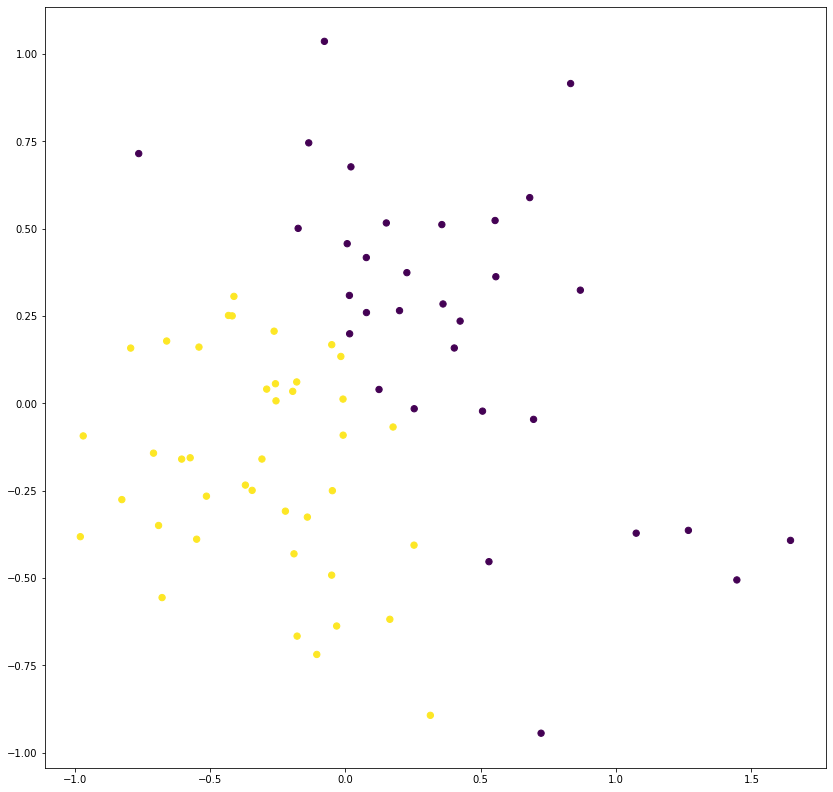

In [56]:
plt.figure(figsize=(14, 14))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=40, c=clusters)
plt.show()

In [84]:
clus_0 = np.argwhere(clusters == 0)#значения текстов в списке dataset входящих в кластер 0
clus_1 = np.argwhere(clusters == 1)#значения текстов в списке dataset входящих в кластер 1



In [95]:
len(clus_1)

41

In [93]:
print(dataset['text'][clus_0[0][0]])
print(dataset['text'][clus_0[1][0]])

MISTER QUILTER IS THE APOSTLE OF THE MIDDLE CLASSES AND WE ARE GLAD TO WELCOME HIS GOSPEL
IT IS OBVIOUSLY UNNECESSARY FOR US TO POINT OUT HOW LUMINOUS THESE CRITICISMS ARE HOW DELICATE IN EXPRESSION
